In [1]:
import os, sys
from pathlib import Path

# Add parent directory to sys.path
parent_dir = Path.cwd().parent.resolve()
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

# Verify that the path has been added correctly
print(sys.path[0])

from diffusers import FluxPipeline
from diffusers.models import AutoencoderTiny
import torch
import os
os.environ['HF_HOME'] = '/dlabscratch1/anmari'
os.environ['TRANSFORMERS_CACHE'] = '/dlabscratch1/anmari'
os.environ['HF_DATASETS_CACHE'] = '/dlabscratch1/anmari'
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from PIL import Image
from importlib import reload

/claire-rcp-scratch/home/santelmo/dit-editor


In [2]:
from diffusers import FluxPipeline

dtype = torch.float16
pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-dev", 
                                    device_map="balanced",
                                    torch_dtype=dtype)
pipe.set_progress_bar_config(disable=True)

model_index.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

Fetching 23 files:   0%|          | 0/23 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.53G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/782 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

(…)pytorch_model-00001-of-00003.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/378 [00:00<?, ?B/s]

(…)pytorch_model-00003-of-00003.safetensors:   0%|          | 0.00/3.87G [00:00<?, ?B/s]

(…)ion_pytorch_model.safetensors.index.json:   0%|          | 0.00/121k [00:00<?, ?B/s]

(…)pytorch_model-00002-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/820 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [3]:
import cache_and_edit
reload(cache_and_edit)
from cache_and_edit import *
import cache_and_edit.hooks
reload(cache_and_edit.hooks)

from cache_and_edit.inversion import image2latent, get_inverted_input_noise

cached_pipe = CachedPipeline(pipe)
# cached_pipe_dest = CachedPipeline(pipe)

In [4]:
from typing import Optional, Tuple

def resize_bounding_box(
    bb_mask: torch.Tensor,
    target_size: Tuple[int, int] = (64, 64),
) -> torch.Tensor:
    """
    Given a bounding box mask, patches it into a mask with the target size.
    The mask is a 2D tensor of shape (H, W) where each element is either 0 or 1.
    Any patch that contains at least one 1 in the original mask will be set to 1 in the output mask.

    Args:
        bb_mask (torch.Tensor): The bounding box mask as a boolean tensor of shape (H, W).
        target_size (Tuple[int, int]): The size of the target mask as a tuple (H, W).

    Returns:
        torch.Tensor: The resized bounding box mask as a boolean tensor of shape (H, W).
    """
    
    w_mask, h_mask = bb_mask.shape[-2:]
    w_target, h_target = target_size

    # Make sure the sizes are compatible
    if w_mask % w_target != 0 or h_mask % h_target != 0:
        raise ValueError(
            f"Mask size {bb_mask.shape[-2:]} is not compatible with target size {target_size}"
        )
    
    # Compute the size of a patch
    patch_size = (w_mask // w_target, h_mask // h_target)

    # Iterate over the mask, one patch at a time, and save a 0 patch if the patch is empty or a 1 patch if the patch is not empty
    out_mask = torch.zeros((w_target, h_target), dtype=bb_mask.dtype, device=bb_mask.device)
    for i in range(w_target):
        for j in range(h_target):
            patch = bb_mask[
                i * patch_size[0] : (i + 1) * patch_size[0],
                j * patch_size[1] : (j + 1) * patch_size[1],
            ]
            if torch.sum(patch) > 0:
                out_mask[i, j] = 1
            else:
                out_mask[i, j] = 0

    return out_mask


def get_combined_latents(
    bg_latents: torch.Tensor,
    fg_latents: torch.Tensor,
    bb_mask: torch.Tensor,
) -> torch.Tensor:
    """
    Given a background and foreground latents, and a bounding box mask,
    combine the latents into a single tensor by putting the foreground latents
    inside the bounding box mask and the background latents outside of it.

    Args:
        bg_latents (torch.Tensor): The background latents as a tensor of shape (H * W, C).
        fg_latents (torch.Tensor): The foreground latents as a tensor of shape (H * W, C).
        bb_mask (torch.Tensor): The bounding box mask as a boolean tensor of shape (H * W, ).

    Returns:
        torch.Tensor: The combined latents as a tensor of shape (H * W, C).

    """

    if bb_mask.ndim == 2:
        bb_mask = bb_mask.flatten()

    assert bg_latents.shape == fg_latents.shape, "Background and foreground latents must have the same shape"
    assert bg_latents.shape[0] == bb_mask.shape[0], "Background latents and bounding box mask must have the same number of elements"
    assert fg_latents.shape[0] == bb_mask.shape[0], "Foreground latents and bounding box mask must have the same number of elements"

    if bb_mask.dtype == torch.bool:
        bb_mask = bb_mask.float()
    if bb_mask.ndim == 1:
        bb_mask = bb_mask.unsqueeze(1)

    
    # Create a new tensor to hold the combined latents
    combined_latents = bg_latents * (1 - bb_mask) + fg_latents * bb_mask
    return combined_latents    

In [ ]:
from typing import Optional, Tuple
import torch
import torchvision.transforms.functional as TF

def place_image_in_bounding_box(
    image_tensor_whc: torch.Tensor, 
    mask_tensor_wh: torch.Tensor
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Resizes an input image to fit within a bounding box (from a mask)
    preserving aspect ratio, and places it centered on a new canvas.

    Args:
        image_tensor_whc: Input image tensor, shape [width, height, channels].
        mask_tensor_wh: Bounding box mask, shape [width, height]. Defines canvas size
                          and contains a rectangle of 1s for the BB.

    Returns:
        A tuple:
        - output_image_whc (torch.Tensor): Canvas with the resized image placed.
                                           Shape [canvas_width, canvas_height, channels].
        - new_mask_wh (torch.Tensor): Mask showing the actual placement of the image.
                                      Shape [canvas_width, canvas_height].
    """
    
    # Validate input image dimensions
    if not (image_tensor_whc.ndim == 3 and image_tensor_whc.shape[0] > 0 and image_tensor_whc.shape[1] > 0):
        raise ValueError(
            "Input image_tensor_whc must be a 3D tensor [width, height, channels] "
            "with width > 0 and height > 0."
        )
    img_orig_w, img_orig_h, num_channels = image_tensor_whc.shape

    # Validate mask tensor dimensions
    if not (mask_tensor_wh.ndim == 2):
        raise ValueError("Input mask_tensor_wh must be a 2D tensor [width, height].")
    canvas_w, canvas_h = mask_tensor_wh.shape

    # Prepare default empty outputs for early exit scenarios
    empty_output_image = torch.zeros(
        canvas_w, canvas_h, num_channels, 
        dtype=image_tensor_whc.dtype, device=image_tensor_whc.device
    )
    empty_new_mask = torch.zeros(
        canvas_w, canvas_h, 
        dtype=mask_tensor_wh.dtype, device=mask_tensor_wh.device
    )

    # 1. Find Bounding Box (BB) coordinates from the input mask_tensor_wh
    #    fg_coords shape: [N, 2], where N is num_nonzero. Each row: [x_coord, y_coord].
    fg_coords = torch.nonzero(mask_tensor_wh, as_tuple=False) 
    
    if fg_coords.numel() == 0: # No bounding box found in mask
        return empty_output_image, empty_new_mask

    # Determine min/max extents of the bounding box
    x_min_bb, y_min_bb = fg_coords[:, 0].min(), fg_coords[:, 1].min()
    x_max_bb, y_max_bb = fg_coords[:, 0].max(), fg_coords[:, 1].max()

    bb_target_w = x_max_bb - x_min_bb + 1
    bb_target_h = y_max_bb - y_min_bb + 1

    if bb_target_w <= 0 or bb_target_h <= 0: # Should not happen if fg_coords not empty
        return empty_output_image, empty_new_mask

    # 2. Prepare image for resizing: TF.resize expects [C, H, W]
    #    Input image_tensor_whc is [W, H, C]. Permute to [C, H_orig, W_orig].
    image_tensor_chw = image_tensor_whc.permute(2, 1, 0) 

    # 3. Calculate new dimensions for the image to fit in BB, preserving aspect ratio
    scale_factor_w = bb_target_w / img_orig_w
    scale_factor_h = bb_target_h / img_orig_h
    scale = min(scale_factor_w, scale_factor_h) # Fit entirely within BB

    resized_img_w = int(img_orig_w * scale)
    resized_img_h = int(img_orig_h * scale)
    
    if resized_img_w == 0 or resized_img_h == 0: # Image scaled to nothing
        return empty_output_image, empty_new_mask
        
    # 4. Resize the image. TF.resize expects size as [H, W].
    try:
        # antialias=True for better quality (requires torchvision >= 0.8.0 approx)
        resized_image_chw = TF.resize(image_tensor_chw, [resized_img_h, resized_img_w], antialias=True)
    except TypeError: # Fallback for older torchvision versions
        resized_image_chw = TF.resize(image_tensor_chw, [resized_img_h, resized_img_w])

    # Permute resized image back to [W, H, C] format
    resized_image_whc = resized_image_chw.permute(2, 1, 0)

    # 5. Create the output canvas image (initialized to zeros)
    output_image_whc = torch.zeros(
        canvas_w, canvas_h, num_channels, 
        dtype=image_tensor_whc.dtype, device=image_tensor_whc.device
    )

    # 6. Calculate pasting coordinates to center the resized image within the original BB
    offset_x = (bb_target_w - resized_img_w) // 2
    offset_y = (bb_target_h - resized_img_h) // 2

    paste_x_start = x_min_bb + offset_x
    paste_y_start = y_min_bb + offset_y

    paste_x_end = paste_x_start + resized_img_w
    paste_y_end = paste_y_start + resized_img_h
    
    # Place the resized image onto the canvas
    output_image_whc[paste_x_start:paste_x_end, paste_y_start:paste_y_end, :] = resized_image_whc

    # 7. Create the new mask representing where the image was actually placed
    new_mask_wh = torch.zeros(
        canvas_w, canvas_h, 
        dtype=mask_tensor_wh.dtype, device=mask_tensor_wh.device
    )
    new_mask_wh[paste_x_start:paste_x_end, paste_y_start:paste_y_end] = 1

    return output_image_whc, new_mask_wh


def resize_bounding_box(
    bb_mask: torch.Tensor,
    target_size: Tuple[int, int] = (64, 64),
) -> torch.Tensor:
    """
    Given a bounding box mask, patches it into a mask with the target size.
    The mask is a 2D tensor of shape (H, W) where each element is either 0 or 1.
    Any patch that contains at least one 1 in the original mask will be set to 1 in the output mask.

    Args:
        bb_mask (torch.Tensor): The bounding box mask as a boolean tensor of shape (H, W).
        target_size (Tuple[int, int]): The size of the target mask as a tuple (H, W).

    Returns:
        torch.Tensor: The resized bounding box mask as a boolean tensor of shape (H, W).
    """
    
    w_mask, h_mask = bb_mask.shape[-2:]
    w_target, h_target = target_size

    # Make sure the sizes are compatible
    if w_mask % w_target != 0 or h_mask % h_target != 0:
        raise ValueError(
            f"Mask size {bb_mask.shape[-2:]} is not compatible with target size {target_size}"
        )
    
    # Compute the size of a patch
    patch_size = (w_mask // w_target, h_mask // h_target)

    # Iterate over the mask, one patch at a time, and save a 0 patch if the patch is empty or a 1 patch if the patch is not empty
    out_mask = torch.zeros((w_target, h_target), dtype=bb_mask.dtype, device=bb_mask.device)
    for i in range(w_target):
        for j in range(h_target):
            patch = bb_mask[
                i * patch_size[0] : (i + 1) * patch_size[0],
                j * patch_size[1] : (j + 1) * patch_size[1],
            ]
            if torch.sum(patch) > 0:
                out_mask[i, j] = 1
            else:
                out_mask[i, j] = 0

    return out_mask


def get_combined_latents(
    bg_latents: torch.Tensor,
    fg_latents: torch.Tensor,
    bb_mask: torch.Tensor,
) -> torch.Tensor:
    """
    Given a background and foreground latents, and a bounding box mask,
    combine the latents into a single tensor by putting the foreground latents
    inside the bounding box mask and the background latents outside of it.

    Args:
        bg_latents (torch.Tensor): The background latents as a tensor of shape (H * W, C).
        fg_latents (torch.Tensor): The foreground latents as a tensor of shape (H * W, C).
        bb_mask (torch.Tensor): The bounding box mask as a boolean tensor of shape (H * W, ).

    Returns:
        torch.Tensor: The combined latents as a tensor of shape (H * W, C).

    """

    if bb_mask.ndim == 2:
        bb_mask = bb_mask.flatten()

    assert bg_latents.shape == fg_latents.shape, "Background and foreground latents must have the same shape"
    assert bg_latents.shape[0] == bb_mask.shape[0], "Background latents and bounding box mask must have the same number of elements"
    assert fg_latents.shape[0] == bb_mask.shape[0], "Foreground latents and bounding box mask must have the same number of elements"

    if bb_mask.dtype == torch.bool:
        bb_mask = bb_mask.float()
    if bb_mask.ndim == 1:
        bb_mask = bb_mask.unsqueeze(1)

    
    # Create a new tensor to hold the combined latents
    combined_latents = bg_latents * (1 - bb_mask) + fg_latents * bb_mask
    return combined_latents    

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

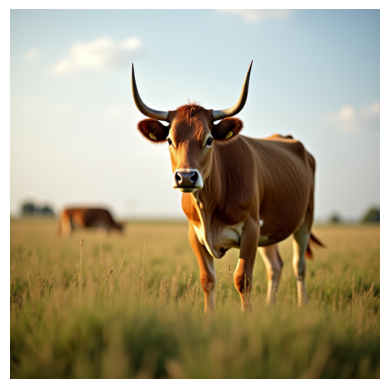

In [6]:
fg_img = cached_pipe.run(
    "a cow in a field",
    num_inference_steps=28,
    seed=42,
    guidance_scale=3.5,
).images[0]

# Display the generated image (resized to 512x512)
plt.imshow(fg_img.resize((512, 512)))
plt.axis("off")

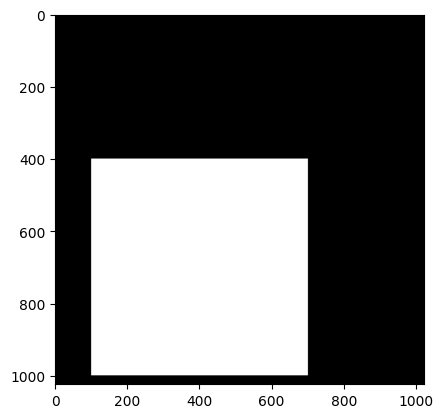

In [7]:
bb_mask = torch.zeros((1024, 1024), dtype=bool)
bb_mask[400:1000, 100:700] = 1

# Show mask
plt.imshow(bb_mask.cpu().numpy(), cmap="gray")

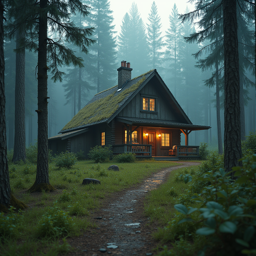

In [8]:
bg_img = cached_pipe.run(
    "a house in the forest",
    num_inference_steps=28,
    seed=42,
    guidance_scale=3.5,
).images[0]
bg_img.resize((256, 256))

In [9]:
reframed_fg_img, resized_mask = place_image_in_bounding_box(
    torch.tensor(np.array(fg_img)),
    bb_mask
)
# resized_mask <- resize the mask to match with the patch size

In [10]:
fg_noise = get_inverted_input_noise(cached_pipe, Image.fromarray(reframed_fg_img.cpu().numpy()), 100)

In [11]:
bg_noise = get_inverted_input_noise(cached_pipe, bg_img, 100)

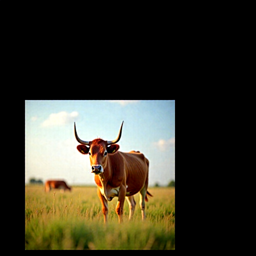

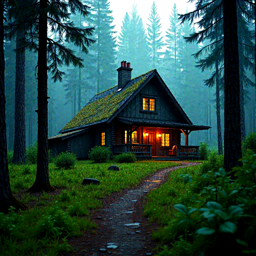

In [12]:
# Make sure inversions were decent

display(cached_pipe.run(
    "",
    num_inference_steps=28,
    seed=42,
    guidance_scale=3.5,
    latents=fg_noise.unsqueeze(0),
).images[0].resize((256, 256)))

display(cached_pipe.run(
    "",
    num_inference_steps=28,
    seed=42,
    guidance_scale=3.5,
    latents=bg_noise.unsqueeze(0),
).images[0].resize((256, 256)))

In [13]:
resized_mask.shape

torch.Size([1024, 1024])

In [14]:
resized_mask = resize_bounding_box(resized_mask, (64, 64)).flatten()

In [ ]:
resized_mask = resized_mask.unsqueeze(-1)
resized_mask = resized_mask.to("cuda")
resized_mask = resized_mask.to(dtype=torch.int)

In [23]:
# Combined noises: 
## Take the background noise for outside the mask and the foreground noisefor inside the mask
combined_noises  = fg_noise * resized_mask + bg_noise * (1 - resized_mask)

In [50]:
alpha = 0.3
combined_noises = ((1 - alpha) * bg_noise * resized_mask / 2 + bg_noise * (1 - resized_mask) + alpha * fg_noise * resized_mask / 2)

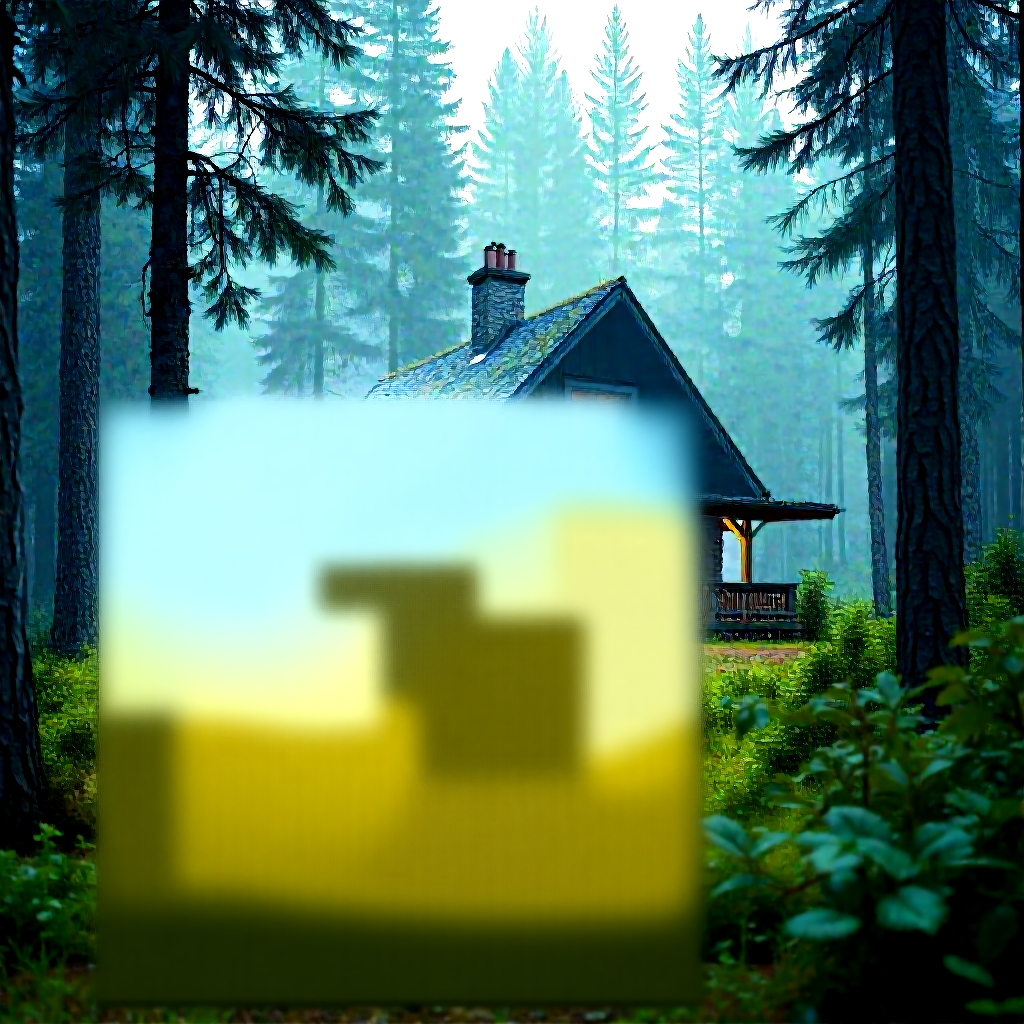

In [51]:
display(cached_pipe.run(
    "",
    num_inference_steps=28,
    seed=42,
    guidance_scale=3.5,
    latents=combined_noises.unsqueeze(0),
).images[0])